<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/JaxPM/blob/main/notebooks/Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git
!hostname
!python -c "import jax; print(jax.default_backend())"

feynmangpu04.cluster.local


gpu


In [1]:
%matplotlib inline
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.33' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt

import numpy as np
import jax
import jax.numpy as jnp
import jax_cosmo as jc

from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint
from jaxpm.pm import linear_field, lpt, make_ode_fn

In [2]:
mesh_shape= [256, 256, 256]
box_size  = [256.,256.,256.]
n_snapshots = 4
snapshots = jnp.linspace(0.1,1.,n_snapshots)

@jax.jit
def run_simulation(cosmology):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmology, k)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)
    # pk_fn = lambda x: jc.power.linear_matter_power(jc.Planck15(Omega_c=omega_c, sigma8=sigma8), x.reshape([-1])).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))

    # Create particles
    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])

    # Initial displacement
    cosmology._workspace = {}  # FIX ME: this a temporary fix
    dx, p, f = lpt(cosmology, initial_conditions, particles, 0.1)
    
    # Evolve the simulation forward
    res = odeint(make_ode_fn(mesh_shape), [particles+dx, p], snapshots, cosmology, rtol=1e-5, atol=1e-5)
    
    # Return the simulation volume at requested 
    return res

2024-01-09 23:04:45.462232: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [6]:
cosmology = jc.Planck15(Omega_c=0.25, sigma8=0.8)
res = run_simulation(cosmology)
# %timeit res = run_simulation(cosmology)

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


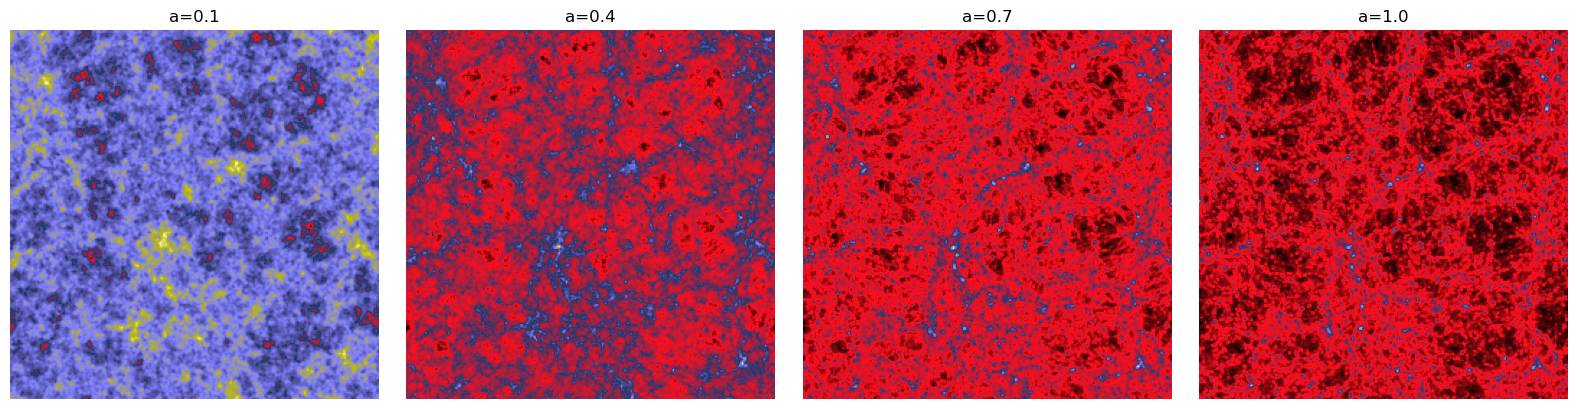

In [ ]:
obs_mesh = np.array([cic_paint(jnp.zeros(mesh_shape), res[0][i_snapshot]).mean(axis=0) for i_snapshot in range(n_snapshots)])
vmin, vmax = None, None

plt.figure(figsize=[16,4])
for i_snapshot in range(n_snapshots):
    plt.subplot(1,n_snapshots,i_snapshot+1)
    plt.imshow(obs_mesh[i_snapshot], vmin=vmin, vmax=vmax, cmap='gist_stern')
    plt.title(f"a={snapshots[i_snapshot]:.1f}");
    plt.axis("off")
plt.tight_layout();

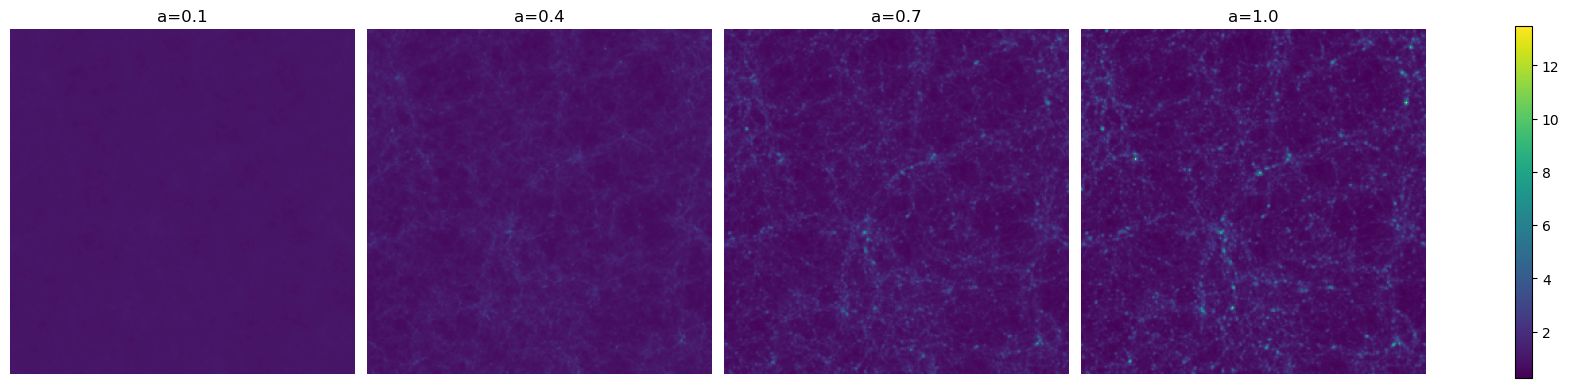

In [ ]:
obs_mesh = np.array([cic_paint(jnp.zeros(mesh_shape), res[0][i_snapshot]).mean(axis=0) for i_snapshot in range(n_snapshots)])
vmin, vmax = obs_mesh.min(), obs_mesh.max()

plt.figure(figsize=[18,4])
for i_snapshot in range(n_snapshots):
    plt.subplot(1,n_snapshots,i_snapshot+1)
    plt.imshow(obs_mesh[i_snapshot], vmin=vmin, vmax=vmax)
    plt.title(f"a={snapshots[i_snapshot]:.1f}");
    plt.axis("off")
plt.tight_layout();
plt.colorbar(ax=plt.gcf().axes);